In [1]:
from moneymaker.data_retriever.data_retriever import get_daily_bars
from moneymaker.universe_creators.sp_500_creator import sp_500_creator
from moneymaker.position_sizers.ATRPositionSizer import ATRPositionSizer
from moneymaker.position_sizers.EqualPositionSizer import EqualPositionSizer
from moneymaker.broker.BacktestBroker import BacktestBroker
from datetime import datetime, timedelta
from sklearn.pipeline import make_pipeline
import moneymaker as mm
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client

plt.rcParams["axes.grid"] = True
plt.style.use("dark_background")
plt.rcParams["grid.color"] = "#222222"
plt.rcParams["figure.figsize"] = (20, 10)

pd.options.display.max_rows = 150


ImportError: cannot import name 'credentials' from 'moneymaker.data_retriever' (C:\Users\Jacob\Desktop\FGH\moneymaker\moneymaker\data_retriever\__init__.py)

In [276]:
#start_datetime = datetime.fromisoformat("2018-03-31")
start_datetime = datetime.fromisoformat("1998-03-31")
end_datetime = datetime.fromisoformat("2021-03-31")

short_period = 100
long_period = 200
atr_period = 20

In [3]:
def _momentum(the_array):
    r = np.log(the_array)
    slope, _, rvalue, _, _ = linregress(np.arange(len(r)), r)
    annualized = -1 + (np.e ** slope) ** 252
    return annualized * (rvalue ** 2)


def momentum(close, **kwargs):
    return (
        close.rolling(kwargs["horizon"])
        .apply(_momentum)
        .rename({"close": "momentum"}, axis="columns")
    )


def create_multiindex(df: pd.DataFrame, **kwargs):
    idx = df.index.to_frame()
    idx.insert(1, "ticker", kwargs["ticker"])
    df.index = pd.MultiIndex.from_frame(idx)
    return df


In [4]:
sp_500 = sp_500_creator(start_datetime, end_datetime).get_history()


In [5]:
sp_500

{'HET': [['1998-04-01', '2008-03-31']],
 'PKI': [['1998-04-01', '2021-03-31']],
 'DE': [['1998-04-01', '2021-03-31']],
 'CSR1': [['1998-04-01', '2000-06-30']],
 'CPQ': [['1998-04-01', '2002-06-30']],
 'VIAC': [['1998-04-01', '2021-03-31']],
 'OAT': [['1998-04-01', '2001-09-30']],
 'AAPL': [['1998-04-01', '2021-03-31']],
 'D': [['1998-04-01', '2021-03-31']],
 'K': [['1998-04-01', '2021-03-31']],
 'AAMRQ': [['1998-04-01', '2003-03-31']],
 'MAS': [['1998-04-01', '2021-03-31']],
 'FCX': [['1998-04-01', '2021-03-31']],
 'GT': [['1998-04-01', '2019-03-31']],
 'MCD': [['1998-04-01', '2021-03-31']],
 'EIX': [['1998-04-01', '2021-03-31']],
 'ETR': [['1998-04-01', '2021-03-31']],
 'UCM': [['1998-04-01', '2000-12-31']],
 'GD': [['1998-04-01', '2021-03-31']],
 'HLT1': [['1998-04-01', '2007-12-31']],
 'MIR1': [['1998-04-01', '2000-06-30']],
 'AZA.A': [['1998-04-01', '2001-06-30']],
 'PCAR': [['1998-04-01', '2021-03-31']],
 'NTRS': [['1998-04-01', '2021-03-31']],
 'MAT': [['1998-04-01', '2019-06-30'

In [6]:
def transform_and_add_indicators(data_dict: dict):
    data = get_daily_bars(
        data_dict["ticker"],
        data_dict["start"] - timedelta(days=int(data_dict["long_period"] * (7 / 5))),
        data_dict["end"],
        folder_path="data/",
        store_data=True,
        security_type= data_dict["security_type"]
    )
    return make_pipeline(
        mm.FromSharadarToOHLCV(),
        mm.make_union(
            make_pipeline(mm.FromOHLCV("ohlcv")),
            make_pipeline(
                mm.FromOHLCV("c"), mm.Wrapper(momentum, horizon=data_dict["short_period"])
            ),
            make_pipeline(mm.FromOHLCV("c"), mm.MA([data_dict["short_period"], data_dict["long_period"]])),
            make_pipeline(mm.FromOHLCV("ohlc"), mm.ATR(window=data_dict["atr_period"])),
            make_pipeline(mm.FromOHLCV("c"), mm.FractionOfHigh(data_dict["short_period"])),
            make_pipeline(mm.FromOHLCV("c"), mm.RateOfChange(data_dict["short_period"])),
        ),
        mm.Wrapper(lambda df: df.dropna()),
        mm.Wrapper(create_multiindex, ticker=data_dict["ticker"]),
    ).fit_transform(data)


In [7]:
delayed_dfs = []
for ticker in sp_500.keys():
    for start, end in sp_500[ticker]:
        data_dict = {
            "ticker": ticker,
            "start": datetime.fromisoformat(start),
            "end": datetime.fromisoformat(end),
            "short_period": short_period,
            "long_period": long_period,
            "atr_period": atr_period,
            "security_type": "stock"
        }
        delayed_df = dask.delayed(transform_and_add_indicators)(data_dict)
        delayed_dfs.append(delayed_df)


In [8]:
client = Client(n_workers=4)
datastreams = dask.compute(*delayed_dfs)
client.close()


In [9]:
datastreams = list(datastreams)
datastreams.append(
    transform_and_add_indicators(
        {
            "ticker": "SPY",
            "start": datetime.fromisoformat("1998-04-01"),
            "end": end_datetime,
            "short_period": short_period,
            "long_period": long_period,
            "atr_period": atr_period,
            "security_type": "bond",
        }
    )
)


In [10]:
dt_data = pd.concat(datastreams, axis="index", levels=0).sort_index(level=[0, 1])
dt_data.to_parquet("dt_data.parquet")


In [277]:
dt_data = pd.read_parquet("dt_data.parquet")

In [278]:
dt_data["mom"] = dt_data["momentum"] * dt_data["foh"]

In [286]:
short_ma = "ma" + str(short_period)
long_ma = "ma" + str(long_period)
position_sizer = ATRPositionSizer(0.005)
#position_sizer = EqualPositionSizer(0.10)
broker = BacktestBroker(
    start_capital=10000, fees=0.001, allow_margin=True, benchmark="SPY"
)
previous_ohlc = None
previous_date = None
date = None
ohlc = None
month = -1
for date, ohlc in dt_data.groupby("date"):
    year, week_number, week_day = date.isocalendar()
    ohlc.index = ohlc.index.droplevel("date")
    broker.update(ohlc, date, previous_ohlc, previous_date)
    account_value = broker.get_value(ohlc, previous_ohlc)

    estimated_cash = broker.cash

    ohlc.sort_values("momentum", ascending=False, inplace=True)

    #if week_number % 1 == 0 and week_day == 5:
    if date.month != month and date.day > 25:
        month = date.month
        ticker_to_sell = []
        for ticker in broker.open_positions.keys():
            if (
                ohlc.index.get_loc(ticker) > 120
                or broker.open_positions[ticker].purchase_price * 0.8 > ohlc.loc[ticker, "close"]
                or ohlc.loc[ticker, long_ma] > ohlc.loc[ticker, "close"]
            ):
                ticker_to_sell.append(ticker)
                broker.sell_next_bar.append((ticker, broker.open_positions[ticker].size))
                estimated_cash += (
                    broker.open_positions[ticker].size * ohlc.loc[ticker, "close"]
                )

        for ticker, size in position_sizer.rebalance(
            ohlc, broker.get_positions(), account_value
        ):
            if ticker in ticker_to_sell:
                continue
            if ohlc.loc[ticker, "close"] * abs(size) < account_value * 0.01:
                continue
            if size < 0.0:
                broker.sell_next_bar.append((ticker, abs(size)))
                #print(f"Rebalance: {ticker} reduce size by {abs(size)} shares.")
            else:
                broker.buy_next_bar.append((ticker, size))
                #print(f"Rebalance: {ticker} increase size by {size} shares.")

        if ohlc.loc["SPY", "close"] > ohlc.loc["SPY", long_ma]:
            for ticker, data in ohlc.head(100).iterrows():
                if estimated_cash < 0.0:
                    break
                if (
                    data["foh"] >= 0.90
                    and data["roc"] < 1.0
                    and data["roc"] >= 0.25
                    and data[long_ma] < data["close"]
                    and ticker not in broker.open_positions.keys()
                ):
                    size = position_sizer(data, account_value)
                    if size > 0.0:
                        broker.buy_next_bar.append((ticker, size))
                        estimated_cash -= size * data["close"]

    previous_ohlc = ohlc
    previous_date = date

broker.liquidate_positions(ohlc, date)
analysis_df = pd.DataFrame(broker.history)
print(f"Final value: {broker.get_value(ohlc, previous_ohlc)}")


Final value: 436950.9205969761


In [287]:
analysis_df

date          cash  position_value    total_value  positions  \
0    1998-10-15  10000.000000        0.000000   10000.000000          0   
1    1998-10-16  10000.000000        0.000000   10000.000000          0   
2    1998-10-19  10000.000000        0.000000   10000.000000          0   
3    1998-10-20  10000.000000        0.000000   10000.000000          0   
4    1998-10-21  10000.000000        0.000000   10000.000000          0   
...         ...           ...             ...            ...        ...   
5646 2021-03-25  14777.389347   410708.791089  425486.180436          7   
5647 2021-03-26  14777.389347   422176.808592  436954.197939          7   
5648 2021-03-29   7009.851038   419267.550762  426277.401800          8   
5649 2021-03-30   7009.851038   429614.874081  436624.725119          8   
5650 2021-03-31   7009.851038   429941.069559  436950.920597          8   

         benchmark  
0      9999.990000  
1     10002.979321  
2     10038.281777  
3     10097.356451  
4     10061.911646  
...            ...  
5646  55473.254135  
5647  56367.203419  
5648  56338.733697  
5649  56189.267654  
5650  56417.025433  

[5651 rows x 6 columns]

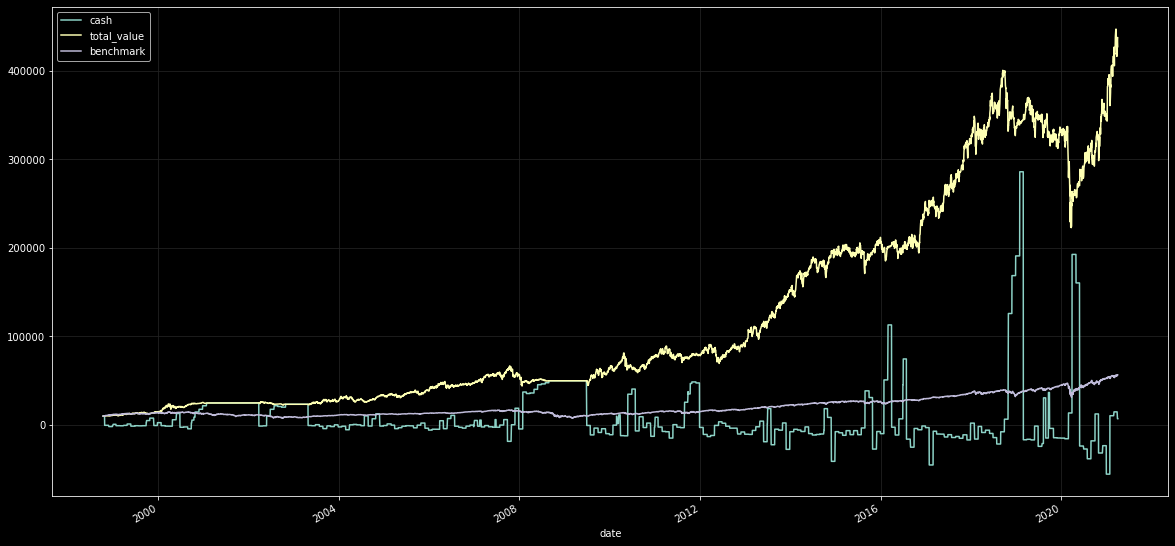

In [288]:
analysis_df[["date", "cash","total_value", "benchmark"]].plot(
    x="date"
);

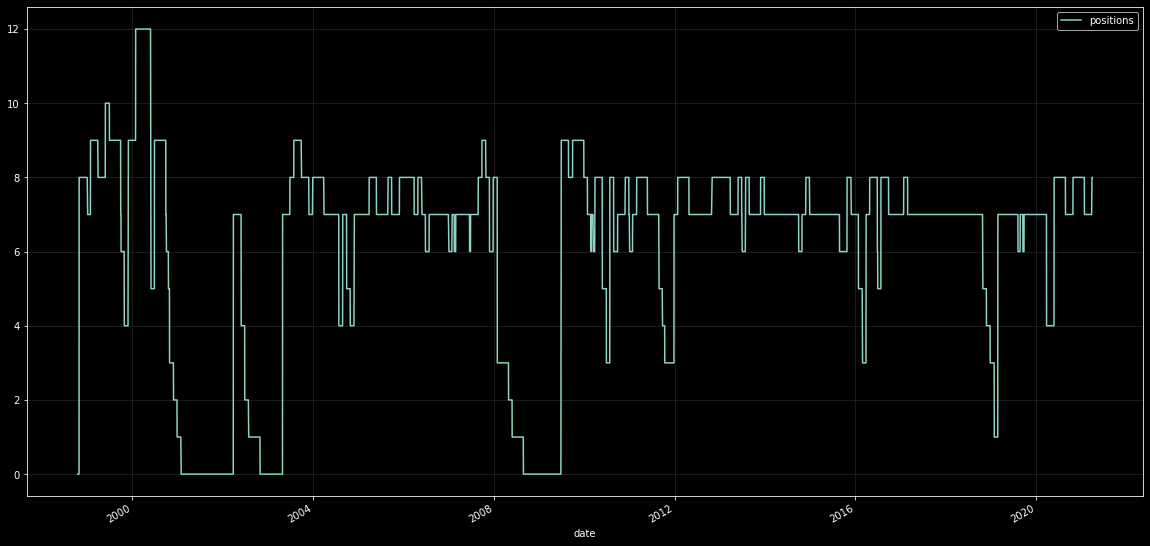

In [289]:
analysis_df[["date", "positions"]].plot(
    x="date"
);

In [290]:
total_profit = 0.0
for position in broker.closed_positions:
    profit = position.selling_price * position.size * (
        1.0 - broker.fees
    ) - position.purchase_price * position.size * (1.0 + broker.fees)
    total_profit += profit
print(f"Total profit calculated from closed positions: {total_profit}")

Total profit calculated from closed positions: 426950.92059697607


In [291]:
trade_returns = []
trade_holding_days = []
for position in broker.closed_positions:
    trade_returns.append(
        (position.selling_price - position.purchase_price) / position.purchase_price
    )
    trade_holding_days.append((position.selling_datetime-position.purchase_datetime).days)

trade_holding_days = pd.Series(trade_holding_days)
trade_returns = pd.Series(trade_returns)


<AxesSubplot:>

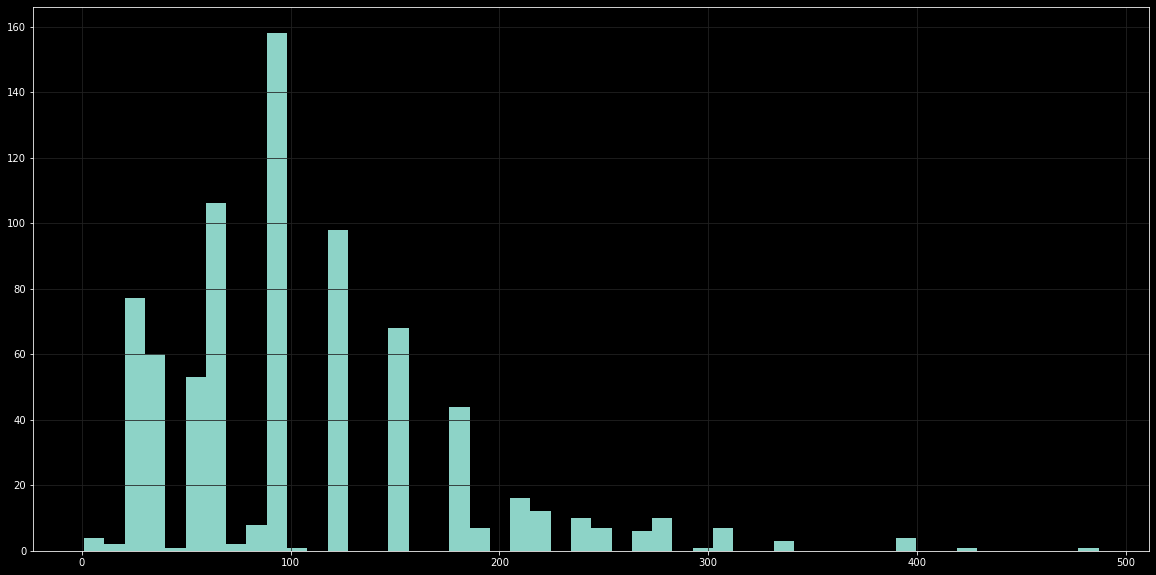

In [292]:
trade_holding_days.hist(bins=50)

<AxesSubplot:>

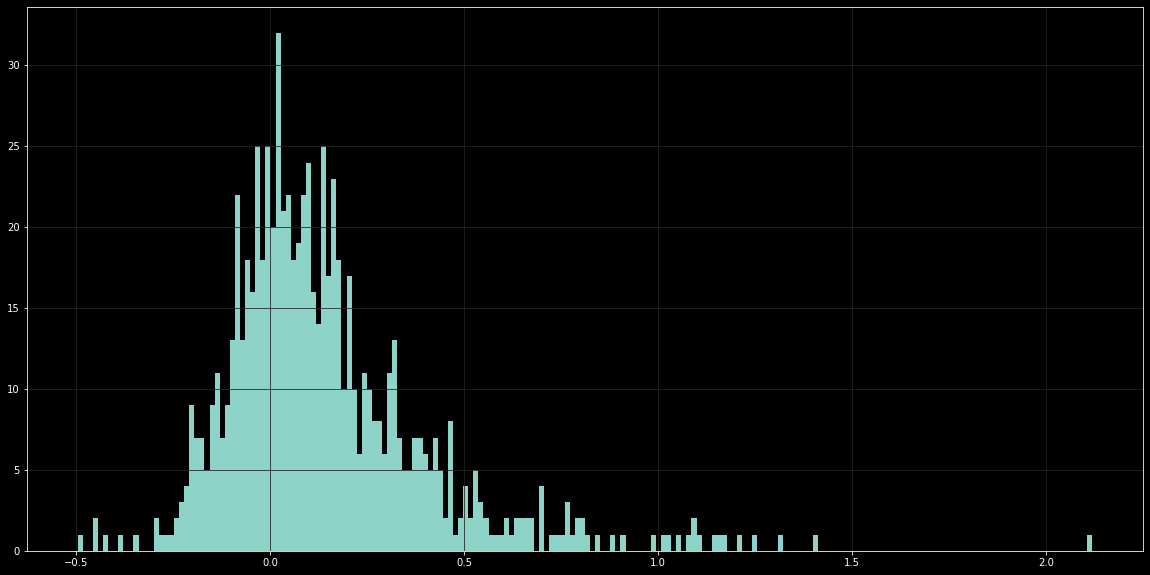

In [293]:
trade_returns.hist(bins=200)

In [294]:
len(broker.closed_positions)

767

In [ ]:
suspicious_positions = []
for position in broker.closed_positions:
    if position.purchase_datetime > datetime.fromisoformat("2020-01-01") and position.purchase_datetime < datetime.fromisoformat("2020-02-01"):
        suspicious_positions.append(position)

In [ ]:
print(suspicious_positions[0])

In [ ]:
dt_ohlcv[
    (
        dt_ohlcv.index.get_level_values(0).isin([
            datetime.fromisoformat("2020-01-08"),
            datetime.fromisoformat("2020-01-09"),
            datetime.fromisoformat("2020-01-10"),
        ])
    )
    & (dt_ohlcv.index.get_level_values(1) == "TIF")
]
